<a href="https://colab.research.google.com/github/tciodaro/GRLCDDR1C1-N2-L2-PB/blob/main/treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd



fname = 'drive/MyDrive/Curso Projeto de Bloco: Inteligência Artificial e Machine Learning (GRLCDDR1C1-N2-L2)/dataset_vinhos.csv'



wine = pd.read_csv(fname, sep=';')
wine


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,target_label,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,baixa qualidade,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,baixa qualidade,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,baixa qualidade,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,alta qualidade,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,0,baixa qualidade,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,alta qualidade,white
5316,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,baixa qualidade,white
5317,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,alta qualidade,white
5318,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,alta qualidade,white


In [79]:
wine['type']

,type
0,red
1,red
2,red
3,red
4,red
...,...
5315,white
5316,white
5317,white
5318,white


In [81]:
from sklearn.model_selection import train_test_split

# wine.shape
# wine['target-type'] = wine['target_label'] + ' ' + wine['type']
# trn, prod = train_test_split(wine, test_size=0.2, stratify=wine['target'], random_state=1)

prod = wine[wine['type'] == 'white']
dev = wine[wine['type'] == 'red']

trn, tst = train_test_split(dev, test_size=0.2, stratify=dev['target'], random_state=1)


print(trn.shape)
print(tst.shape)
print(prod.shape)



(1087, 14)
(272, 14)
(3961, 14)


In [82]:
prod.to_parquet('drive/MyDrive/Curso Projeto de Bloco: Inteligência Artificial e Machine Learning (GRLCDDR1C1-N2-L2)/wine_production.parquet')

In [83]:
from sklearn import preprocessing

feature_list = [
    'pH',	'sulphates',	'alcohol'
]

scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.QuantileTransformer()
scaler = scaler.fit(trn[feature_list])

norm_trn = scaler.transform(trn[feature_list])
norm_tst = scaler.transform(tst[feature_list])

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [85]:



n_neighbors_list = [3,5,7,9,11,13]
weights_list = ['distance', 'uniform']

results = []

for n in n_neighbors_list:
  for w in weights_list:

    knn = KNeighborsClassifier(
        n_neighbors=n,
        weights = w,
        metric='minkowski'
    )
    knn = knn.fit(norm_trn, trn['target'])
    # Avaliar treino
    ytrn = knn.predict_proba(norm_trn)[:,1]
    acc_trn = accuracy_score(y_pred=ytrn > 0.5, y_true = trn['target'])
    # Avaliar teste
    ytst = knn.predict_proba(norm_tst)[:,1]
    acc_tst = accuracy_score(y_pred=ytst > 0.5, y_true = tst['target'])

    # Guardar resultados em dicionario
    results.append({
        'n_neighbors': n,
        'weights': w,
        'acc_trn': acc_trn,
        'acc_tst': acc_tst
    })
results = pd.DataFrame().from_dict(results)

In [86]:
results.sort_values('acc_tst')

,n_neighbors,weights,acc_trn,acc_tst
1,3,uniform,0.819687,0.687500
3,5,uniform,0.778289,0.691176
0,3,distance,0.995400,0.698529
7,9,uniform,0.768169,0.702206
2,5,distance,0.995400,0.709559
5,7,uniform,0.766329,0.709559
9,11,uniform,0.763569,0.709559
4,7,distance,0.995400,0.713235
6,9,distance,0.995400,0.716912
11,13,uniform,0.761730,0.716912


<Axes: xlabel='n_neighbors'>

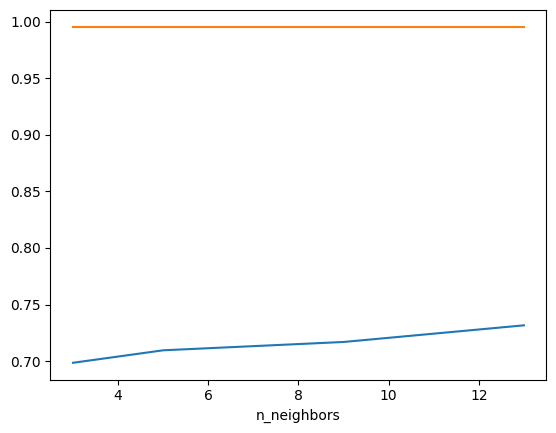

In [87]:
w = 'distance'
results[results.weights == w].set_index('n_neighbors').acc_tst.plot()
results[results.weights == w].set_index('n_neighbors').acc_trn.plot()

In [88]:
knn = KNeighborsClassifier(
      n_neighbors=13,
      weights = 'distance',
      metric='minkowski'
)
knn = knn.fit(norm_trn, trn['target'])

In [89]:
import joblib

joblib.dump(scaler,'drive/MyDrive/Curso Projeto de Bloco: Inteligência Artificial e Machine Learning (GRLCDDR1C1-N2-L2)/scaler.pkl')
joblib.dump(knn,'drive/MyDrive/Curso Projeto de Bloco: Inteligência Artificial e Machine Learning (GRLCDDR1C1-N2-L2)/knn.pkl')

['drive/MyDrive/Curso Projeto de Bloco: Inteligência Artificial e Machine Learning (GRLCDDR1C1-N2-L2)/knn.pkl']